<a href="https://colab.research.google.com/github/wonyoung-ji/study/blob/master/dacon/Predict_Market_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dacon Competition Project : Predict Market Sales

## 1.1.Description
- 핀테크 기업인 'FUNDA'는 상환 기간의 매출을 예측하여 신용 점수가 낮거나 담보를 가지지 못하는 우수상점들에게 금융 기회를 제공하려 합니다. 이번 대회에서는 2년 전부터 2019년 2월 28일까지의 카드 거래 데이터를 이용해 2019-03-01 ~ 2019-05-31까지 각 상점별 3개월 총 매출을 예측하는 것입니다.

## 1.2. Data Field
- store_id: 상점의 고유 아이디
- card_id: 사용한 카드의 고유 아이디
- card_company: 비식별화된 카드 회사
- transacted_date: 거래날짜
- transcated_time: 거래시간(시:분)
- installment_term: 할부 개월 수(포인트 사용시 '60개월 + 실제할부개월'을  할부개월 수에 기재)
- region: 상점 지역
- type_of_business: 상점의 업종
- amount: 거래액 (단위는 원이 아님)

# Index


## 1.Data Load & Resampling
- 시계열 분석을 위한 date index로 변환
- 시간 단위로 나뉘어져 있는 데이터를 일 단위로 resampling
- modeling을 위해 월 단위로 resampling

## 2.EDA
- 변수의 describe 확인
- target 변수의 대칭성 (정규성) 확인
- 각 변수의 value 분포 시각화
- 같은 기간 동안 여러 상점 매출의 추이 및 스케일 확인
- 다른 변수들이 amount와 같은 패턴을 가지는지 확인

## 3.Modeling - Time Series
- Simple Moving Average
- Exponential Moving Average
- Exponential Smooting(Simple, Holt's, Holt-Winter's)
- ARMA
- ARIMA
- Facebook Prophet

## 4.Modeling - Regression
- date index를 독립변수로 생성
- 예측해야 할 test dataset 생성
- test dataset의 null값 대체
- Regression Modeling

## 5.Modeling - Deep Neural Network
- LSTM

In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mlt
import matplotlib.pyplot as plt
from sklearn.externals import joblib      # joblib: 내부에서 pickle을 이용하여 scaler, model 등을 저장하고 읽기 위한 모듈
from sklearn.metrics import make_scorer   # sklearn.metrice: loss, score 등 분류작업의 점수를 측정하기 위한 라이브러리. make_scorer를 사용하여 검증

# 시계열
from fbprophet import Prophet             # facebook prophet
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

# 회귀분석
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Deep Neural Network
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

import warnings
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Evaluate Metric
- MAE(Mean Absolute Error): 절댓값 오차의 평균  

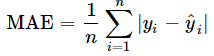 
- validation을 위한 함수 생성 및 make scorer

In [3]:
def mae(prediction, correct):
  prediction = np.array(prediction)
  correct = np.array(correct)

  difference = correct - prediction
  abs_val = abs(difference)

  score = abs_val.mean()
  return score

mae_score = make_scorer(mae)
mae_score

make_scorer(mae)

# Issue




__1) 예측해야 하는 범위는 3개월인데, 데이터는 시간 단위로 나뉘어져 있음__
- month 주기로 resampling 하여 forecast 범위를 3개월로 지정하여 해결  

__2) 1967개의 store_id가 각각의 trend와 seasonality를 가지고 있음__
- 같은 알고리즘에서 각 store_id별로 parameter 조정  

__3) 예측날짜는 2019-03 ~ 2019-05로 동일하나, 제공 데이터의 마지막 날짜는 차이가 있음__
- 마지막 날짜부터 3개월만 예측하여 제출  
(ex. store_id 111의 마지막 날짜는 2018-09로, 뒤 3개월인 2018-10 ~ 2018-12만 예측하여 제출)
- 예측기간이 길어질수록 오차가 크게 발생하여 바로 뒤 3개월만 예측하는 것이 정확도가 높음



# 1.Data Load

## __데이터 기본 정보 확인__

In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/dacon/상점 신용카드 매출 예측/funda_train.csv')
df_sub = pd.read_csv('/content/drive/MyDrive/dacon/상점 신용카드 매출 예측/submission.csv')

In [5]:
df_train['transacted_date'] = pd.to_datetime(df_train['transacted_date'])
df_train.shape

(6556613, 9)

In [6]:
frame_info = [( col,                         #name
              len(df_train[col].unique()),   # num of unique
              df_train[col].isnull().sum(),  # num_nan
              df_train[col].dtype,           # type
              df_train[col].unique()[:5])    # front5_values
              for col in df_train.columns ]

df_info = pd.DataFrame(frame_info, columns = ['name', 'num_of_unique','num_nan','type','front5_values'])

In [7]:
df_info

,name,num_of_unique,num_nan,type,front5_values
0,store_id,1967,0,int64,"[0, 1, 2, 4, 5]"
1,card_id,3950001,0,int64,"[0, 1, 2, 3, 4]"
2,card_company,8,0,object,"[b, h, c, a, f]"
3,transacted_date,1003,0,datetime64[ns],"[2016-06-01T00:00:00.000000000, 2016-06-02T00:..."
4,transacted_time,1440,0,object,"[13:13, 18:12, 18:52, 20:22, 11:06]"
5,installment_term,34,0,int64,"[0, 2, 3, 60, 4]"
6,region,181,2042766,object,"[nan, 서울 종로구, 충북 충주시, 부산 동래구, 경기 평택시]"
7,type_of_business,146,3952609,object,"[기타 미용업, nan, 의복 액세서리 및 모조 장신구 도매업, 한식 음식점업, 배..."
8,amount,30551,0,float64,"[1857.142857142857, 857.1428571428571, 2000.0,..."


## __시계열 분석을 위해 date index로 변환__

In [8]:
df_train = df_train.set_index('transacted_date')
df_train.head(3)

,store_id,card_id,card_company,transacted_time,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,
2016-06-01,0,0,b,13:13,0,NaN,기타 미용업,1857.142857
2016-06-01,0,1,h,18:12,0,NaN,기타 미용업,857.142857
2016-06-01,0,2,c,18:52,0,NaN,기타 미용업,2000.000000


## __시간 단위로 나뉘어져 있는 데이터를 일단위로 resampling__
- `store_id`, `region`, ` type_of_business` 기존과 동일
- `day_of_week`: 각 요일을 나타내는 숫자, 월요일은 0, 일요일은 6
- `business_day`: working day 여부. 1이면 working day, 0이면 주말
- `num_of_pay`: 일 견제 건수, card_id의 count로 생성
- `num_of_revisit`: 단골 방문 횟수. card_id의 value 중 count가 2보다 큰 value의 결제 건수
- `installment_term`: 일 총 할부 개월 수, 기존 installment_term의 합
- `amount`: 일 매출 액. 기존 amount의 합

In [9]:
def resample_day(train_df):
  df_day = pd.DataFrame()
  for i in train_df['store_id'].unique():
    df = train_df[train_df['store_id'] == i]

    # num_of_pay (일별 결제건수)
    count_cols = df['card_id'].resample(rule = 'd').count().rename('num_of_pay')

    # num_of_revisit (단골 방문횟수)
    revisit_idx = df['card_id'].value_counts().reset_index().query('card_id > 2')['index'].values
    revisit_cnt = df[df['card_id'].isin(revisit_idx)]['card_id'].resample(rule='d').count().rename('num_of_revisit')
    
    # installment_term (할부 개월수와 매출액은 일 단위로 합)
    sum_cols = df[['installment_term','amount']].resample(rule='d').sum()
    
    df_num_day = pd.concat([count_cols, revisit_cnt, sum_cols ], axis=1)
    df_num_day.insert(0, 'store_id', i)       #insert(위치, 컬럼명, 넣을값)
    df_num_day.insert(4, 'region', df[df['store_id'] == i]['region'].unique()[0])
    df_num_day.insert(5, 'type_of_business', df[df['store_id']==i]['type_of_business'].unique()[0])

    df_day = pd.concat([df_day, df_num_day],axis=0)
  df_day.insert(1, 'day_of_week', df_day.index.dayofweek)
  df_day.insert(2, 'business_day', df_day.day_of_week.replace({0:1, 2:1, 3:1, 4:1, 5:0, 6:0}).values)
  df_day['num_of_revisit'].fillna(0, inplace=True)
  
  return df_day

In [10]:
%%time
df_day = resample_day(df_train)

CPU times: user 3min 34s, sys: 4.6 s, total: 3min 38s
Wall time: 3min 28s


In [11]:
df_day.head(3)

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2016-06-01,0,2,1,4,4.0,0,NaN,기타 미용업,12571.428571
2016-06-02,0,3,1,7,3.0,0,NaN,기타 미용업,40571.428571
2016-06-03,0,4,1,3,2.0,0,NaN,기타 미용업,18142.857143


In [12]:
df_day.isnull().sum()

store_id                  0
day_of_week               0
business_day              0
num_of_pay                0
num_of_revisit            0
installment_term          0
region               629927
type_of_business    1087791
amount                    0
dtype: int64

In [13]:
# df_day.to_csv('/content/drive/MyDrive/dacon/상점 신용카드 매출 예측/funda_train_day.csv')

In [14]:
df_day = pd.read_csv('/content/drive/MyDrive/dacon/상점 신용카드 매출 예측/funda_train_day.csv')
df_day['transcated_date'] = pd.to_datetime(df_day['transacted_date'])
df_day = df_day.set_index('transcated_date')
df_day.head()

,transacted_date,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transcated_date,,,,,,,,,,
2016-06-01,2016-06-01,0,2,1,4,4.0,0,NaN,기타 미용업,12571.428571
2016-06-02,2016-06-02,0,3,1,7,3.0,0,NaN,기타 미용업,40571.428571
2016-06-03,2016-06-03,0,4,1,3,2.0,0,NaN,기타 미용업,18142.857143
2016-06-04,2016-06-04,0,5,0,7,3.0,0,NaN,기타 미용업,31714.285714
2016-06-05,2016-06-05,0,6,0,3,3.0,0,NaN,기타 미용업,10428.571429


- 각 column간 상관관계 확인

In [15]:
daily_corr = df_day.corr()
daily_corr

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,amount
store_id,1.000000,-0.000040,0.000014,0.042367,0.008061,-0.012184,-0.018348
day_of_week,-0.000040,1.000000,-0.790518,0.016719,-0.038692,-0.013954,-0.021503
business_day,0.000014,-0.790518,1.000000,-0.004598,0.057214,0.015303,0.029468
num_of_pay,0.042367,0.016719,-0.004598,1.000000,0.701121,0.094140,0.265251
num_of_revisit,0.008061,-0.038692,0.057214,0.701121,1.000000,0.071132,0.260674
installment_term,-0.012184,-0.013954,0.015303,0.094140,0.071132,1.000000,0.267498
amount,-0.018348,-0.021503,0.029468,0.265251,0.260674,0.267498,1.000000


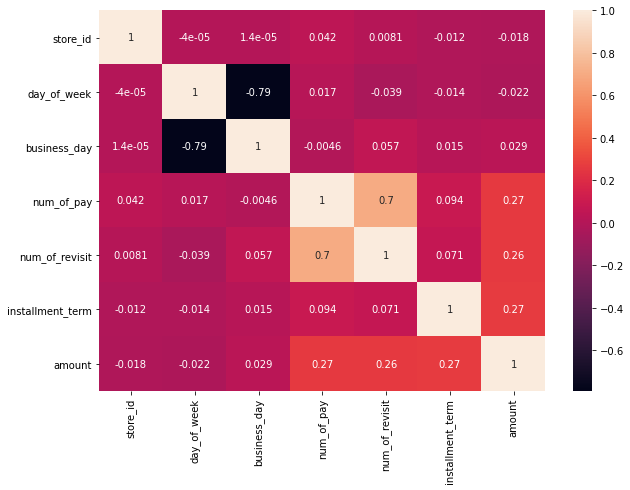

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
sns.heatmap(daily_corr, annot=True)

## __Modeling을 위해 월 단위로 resampling__

In [17]:
df_day.head(3)

,transacted_date,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transcated_date,,,,,,,,,,
2016-06-01,2016-06-01,0,2,1,4,4.0,0,NaN,기타 미용업,12571.428571
2016-06-02,2016-06-02,0,3,1,7,3.0,0,NaN,기타 미용업,40571.428571
2016-06-03,2016-06-03,0,4,1,3,2.0,0,NaN,기타 미용업,18142.857143


In [18]:
def resample_month(frame_day):
  sum_cols = ['num_of_pay', 'num_of_revisit', 'installment_term', 'amount']
  df_monthly = pd.DataFrame()
  for i in frame_day['store_id'].unique():
    df_set = frame_day[frame_day['store_id'] == i]

    # nan 값이 발생하는 경우를 없애기 위해 이전, 이후 달에 대한 정보를 추가한 후 제거
    # store_id별  첫째날 - 한 달 / 첫째날 ~ 마지막날 / 마지막날 + 한 달 별 데이터 생성
    prev_date = pd.date_range(start=(df_set.index[0] - relativedelta(months=1)), end=(df_set.index[0] - relativedelta(months=1)))
    add_date = pd.date_range(start=(df_set.index[-1] + relativedelta(months=1)), end=(df_set.index[-1] + relativedelta(months=1)))
    df_set = pd.concat([pd.DataFrame(index=prev_date), df_set, pd.DataFrame(index=add_date)], axis=0)
    
    df_set.loc[dt.strftime(df_set.index[0], '%Y-%m'), :] = 1
    df_set.loc[dt.strftime(df_set.index[-1], '%Y-%m'), :] = 1

    tot_day = df_set[df_set['amount'] != 0]['day_of_week'].resample(rule='m').count().rename('real_tot_day')
    business = df_set[df_set['amount'] != 0]['business_day'].resample(rule='m').sum().rename('real_business_day')
    
    # 인덱스 0, -1번 drop
    business = business.drop([business.index[0], business.index[-1]], axis=0)
    tot_day = tot_day.drop([tot_day.index[0], tot_day.index[-1]],axis=0)
    df_set = df_set.drop([df_set.index[0], df_set.index[-1]], axis=0)

    df = pd.concat([tot_day, business, df_set[sum_cols].resample(rule='m').sum()], axis=1)

    df.insert(0, 'store_id', i)
    df.insert(6, 'region', df_set['region'].values[0])
    df.insert(7, 'type_of_business', df_set['type_of_business'].values[0])

    df_monthly = pd.concat([df_monthly, df], axis=0)
  
  return df_monthly

In [19]:
%%time
df_month = resample_month(df_day)

CPU times: user 1min 16s, sys: 705 ms, total: 1min 17s
Wall time: 1min 15s


In [20]:
df_month.head()

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
2016-06-30,0,25,17.0,145.0,77.0,13.0,NaN,기타 미용업,7.470000e+05
2016-07-31,0,26,16.0,178.0,105.0,24.0,NaN,기타 미용업,1.005000e+06
2016-08-31,0,24,16.0,171.0,97.0,69.0,NaN,기타 미용업,8.715714e+05
2016-09-30,0,25,19.0,160.0,103.0,15.0,NaN,기타 미용업,8.978571e+05
2016-10-31,0,26,16.0,167.0,115.0,9.0,NaN,기타 미용업,8.354286e+05


- `real_tot_day`: 해당 달의 amount가 1이상인 날의 수
- `real_business_day`: 해당 달의 평일 중 amount가 1이상인 날의 수

In [21]:
df_month.isnull().sum()

store_id                 0
real_tot_day             0
real_business_day        0
num_of_pay               0
num_of_revisit           0
installment_term         0
region               20900
type_of_business     36048
amount                   0
dtype: int64

In [22]:
print('rate of region : ', df_month['region'].isnull().sum()/len(df_month))
print('rate of type of business :', df_month['type_of_business'].isnull().sum() / len(df_month))

rate of region :  0.34310104243618156
rate of type of business : 0.5917754247722236


- 각각 null 값이 34% , 59%에 이르므로, 대체하기도 어려울 뿐더러 오차가 클 것으로 예상되므로 region과 type of business는 삭제

In [23]:
df_month = df_month.drop(['region','type_of_business'], axis=1)
df_month.isnull().sum()

store_id             0
real_tot_day         0
real_business_day    0
num_of_pay           0
num_of_revisit       0
installment_term     0
amount               0
dtype: int64

In [24]:
# df_month.to_csv('/content/drive/MyDrive/dacon/상점 신용카드 매출 예측/funda_train_month.csv')

In [25]:
df_month = pd.read_csv('/content/drive/MyDrive/dacon/상점 신용카드 매출 예측/funda_train_month.csv')
df_month.rename(columns = {'Unnamed: 0' : 'transacted_date'}, inplace=True)
df_month['transacted_date'] = pd.to_datetime(df_month['transacted_date'])
df_month = df_month.set_index('transacted_date')

In [26]:
print(df_month.shape)
df_month.head()

(60915, 7)


,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount
transacted_date,,,,,,,
2016-06-30,0,25,17.0,145.0,77.0,13.0,7.470000e+05
2016-07-31,0,26,16.0,178.0,105.0,24.0,1.005000e+06
2016-08-31,0,24,16.0,171.0,97.0,69.0,8.715714e+05
2016-09-30,0,25,19.0,160.0,103.0,15.0,8.978571e+05
2016-10-31,0,26,16.0,167.0,115.0,9.0,8.354286e+05


# 2.EDA

## __변수 describe 확인__

In [27]:
df_month.describe()

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount
count,60915.000000,60915.000000,60915.000000,60915.000000,60915.000000,60915.000000,6.091500e+04
mean,1050.484281,21.069868,15.896397,107.635443,40.011360,14.875400,1.123188e+06
std,617.483196,7.753269,5.631356,101.244129,43.881331,33.421611,1.753567e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.142857e+05
25%,515.000000,16.000000,12.000000,32.000000,11.000000,0.000000,3.396429e+05
50%,1039.000000,23.000000,17.000000,73.000000,26.000000,3.000000,7.107143e+05
75%,1587.000000,28.000000,21.000000,159.000000,54.000000,14.000000,1.344650e+06
max,2136.000000,31.000000,23.000000,2186.000000,2154.000000,1125.000000,6.142932e+07


## __target 변수 정규성 확인__
- amount별 데이터 분포가 일정한지 확인

Skewness:  0.48245510908400735


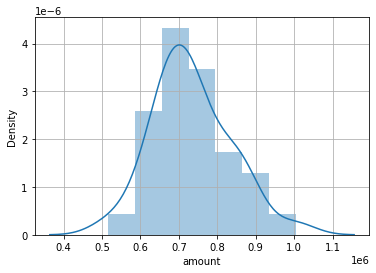

Skewness:  0.5102521050694732


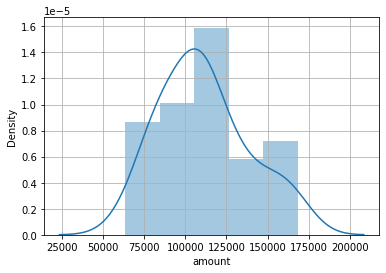

Skewness:  0.9982599271676977


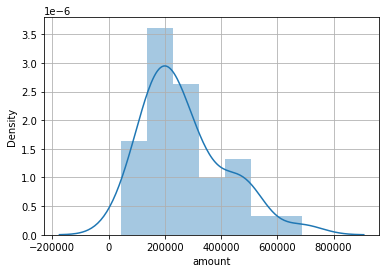

In [28]:
for i in df_month['store_id'].unique()[:3]:
  print('Skewness: ', df_month[df_month['store_id'] == i]['amount'].skew())
  sns.distplot(df_month[df_month['store_id']==i].amount)
  plt.grid()
  plt.show()

-0.5308009496851174


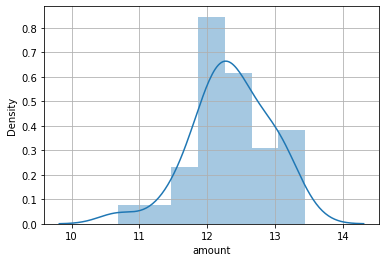

In [29]:
# 로그 적용

print(np.log(df_month[df_month['store_id'] == 2]['amount']).skew())
sns.distplot(np.log(df_month[df_month['store_id'] == 2]['amount']))
plt.grid()
plt.show()

## __각 변수 value 분포 시각화__

In [30]:
df_month.columns

Index(['store_id', 'real_tot_day', 'real_business_day', 'num_of_pay',
       'num_of_revisit', 'installment_term', 'amount'],
      dtype='object')

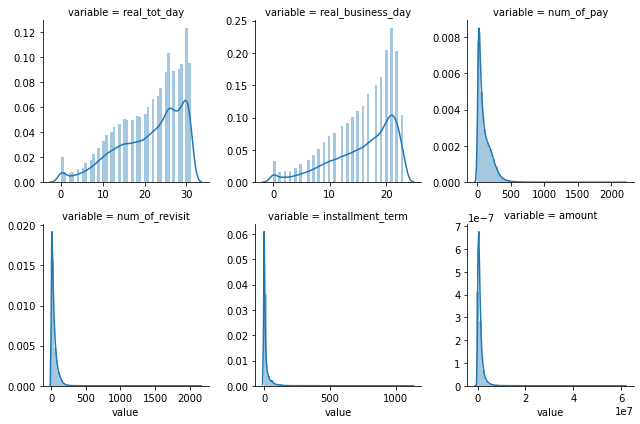

In [31]:
f = pd.melt(df_month, value_vars = df_month.columns[1:])                             # store_id를 제외한 모든 column
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex = False, sharey = False)     # FacetGrid(data,)
g = g.map(sns.distplot, 'value')
plt.show()

## __같은 기간 동안 여러 상점 매출의 추이 및 스케일 확인__
- 전체 store_id 중 0 ~ 7번만 확인
- 각 store_id별 다른 trend와 seasonality, scale을 가지는 것을 확인할 수 있음

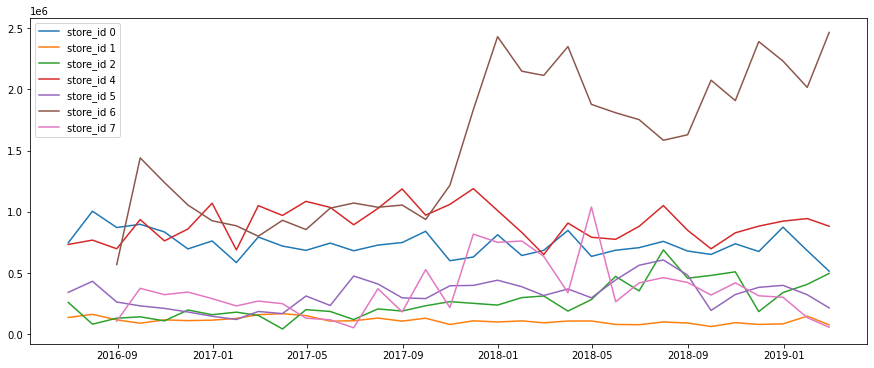

In [32]:
plt.figure(figsize=(15,6))
for i in df_month['store_id'].unique()[:7]:
  plt.plot(df_month[df_month['store_id'] == i].index, df_month[df_month['store_id'] == i]['amount'], label = 'store_id {}'.format(i))
plt.legend()

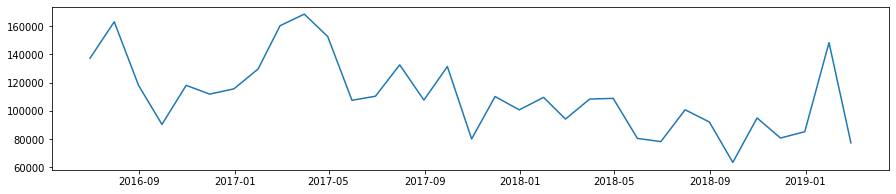

In [33]:
plt.figure(figsize=(15,3))
plt.plot(df_month[df_month['store_id'] == 1].index, df_month[df_month['store_id']==1]['amount'])

## __다른 변수들이 amount와 같은 패턴을 띄는지 확인__

In [34]:
def plot_model_graph(data_frame, store_num, idx_col, y_cols):
  df_set = data_frame[data_frame['store_id'] == store_num]
  
  fig, ax1 = plt.subplots(figsize=(15,3))
  ax1.set_xlabel('{}'.format(idx_col))
  ax1.set_ylabel('{}'.format(y_cols[0])).set_color(color='tab:blue')
  ax1.plot(df_set.index, df_set[y_cols[0]].values, color='tab:blue')

  for i in range(1, len(y_cols)):
    ax2 = ax1.twinx()
    ax2.set_ylabel('{}'.format(y_cols[i])).set_color(color='C{}'.format(i))
    ax2.plot(df_set.index, df_set[y_cols[i]].values, color='C{}'.format(i))
    ax2.spines['right'].set_position(('outward', (60*(i-1))))
    
  fig.tight_layout()
  plt.show()

store_id:  0


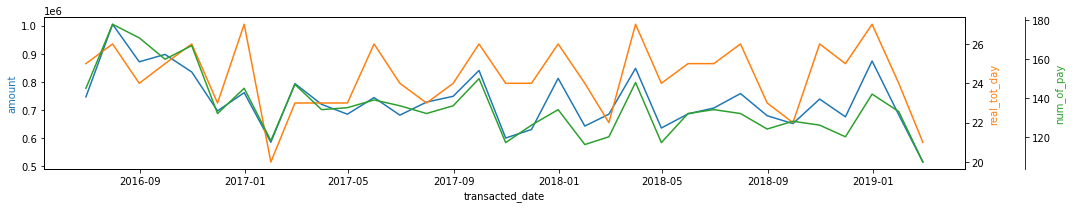

store_id:  1


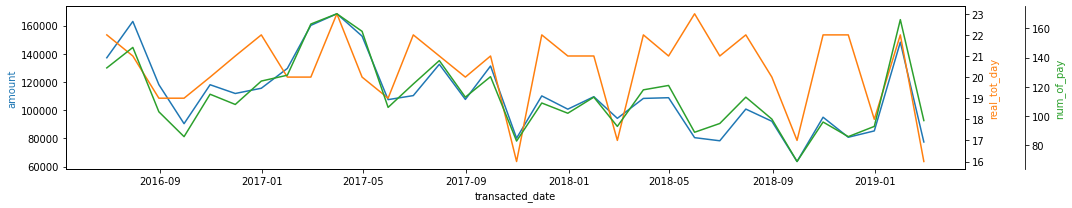

store_id:  2


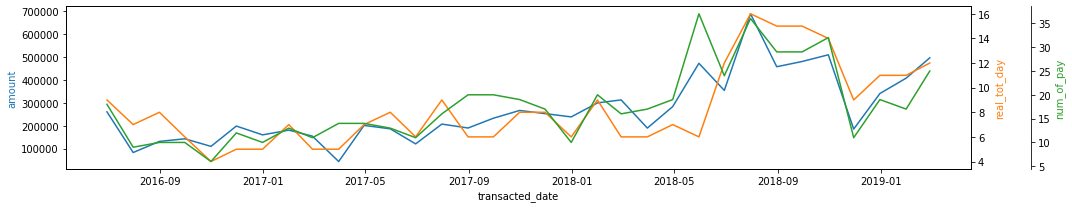

In [35]:
for i in df_month['store_id'].unique()[:3]:
  print('store_id: ', i)
  plot_model_graph(df_month, i, 'transacted_date', ['amount', 'real_tot_day', 'num_of_pay'])

# 3.Modeling - Time Series
- Simple Moving Average
- Exponential Moving Average
- Exponential Smooting(Simple, Holt's, Holt-Winter's)
- ARMA
- ARIMA
- Facebook Prophet

## __Simple Moving Average__
- 단순이동평균은 특정 기간동안의 data를 단순 평균하여 계산한다. 따라서 그 기간 동안의 data를 대표하는 값이 이동평균 안에는 그 동안의 data 움직임을 포함하고 있다.
- 이동편균의 특징인 지연(lag)이 발생하며 수학적으로 n/2 시간 만큼의 지연이 발생한다.
- 단순이동평균은 모든 데이터의 중요도를 동일하다고 간주한다.  
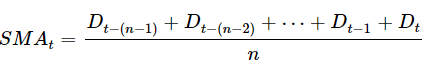

In [36]:
def make_sma_arr(window_num):
  ma_arr = np.array([])
  for i in df_month['store_id'].unique():
    df_set = df_month[df_month['store_id'] == i]
    ma_arr = np.concatenate((ma_arr, df_set['amount'].rolling(window = window_num).mean().values))    # rolling(window=7).mean(): 7개씩 이평 계산

  return ma_arr

In [37]:
sma_month = df_month.copy()
sma_month.insert(7, 'amount_2ma', make_sma_arr(2))
sma_month.insert(8, 'amount_3ma', make_sma_arr(3))
sma_month.insert(9, 'amount_6ma', make_sma_arr(6))

In [38]:
sma_month.head(10)

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount,amount_2ma,amount_3ma,amount_6ma
transacted_date,,,,,,,,,,
2016-06-30,0,25,17.0,145.0,77.0,13.0,7.470000e+05,NaN,NaN,NaN
2016-07-31,0,26,16.0,178.0,105.0,24.0,1.005000e+06,876000.000000,NaN,NaN
2016-08-31,0,24,16.0,171.0,97.0,69.0,8.715714e+05,938285.714286,874523.809524,NaN
2016-09-30,0,25,19.0,160.0,103.0,15.0,8.978571e+05,884714.285714,924809.523810,NaN
2016-10-31,0,26,16.0,167.0,115.0,9.0,8.354286e+05,866642.857143,868285.714286,NaN
2016-11-30,0,23,15.0,132.0,93.0,21.0,6.970000e+05,766214.285714,810095.238095,842309.523810
2016-12-31,0,27,18.0,145.0,103.0,11.0,7.618571e+05,729428.571429,764761.904762,844785.714286
2017-01-31,0,20,15.0,118.0,81.0,4.0,5.856429e+05,673750.000000,681500.000000,774892.857143
2017-02-28,0,23,15.0,147.0,97.0,20.0,7.940000e+05,689821.428571,713833.333333,761964.285714


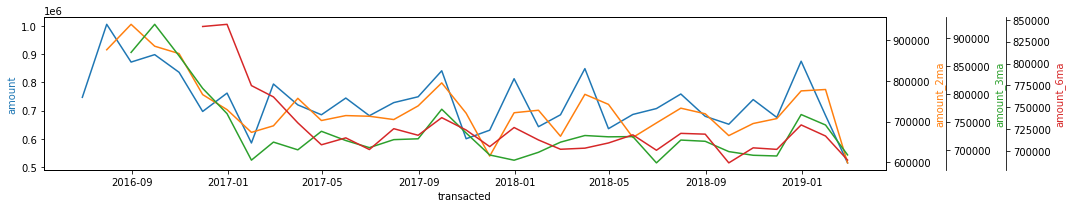

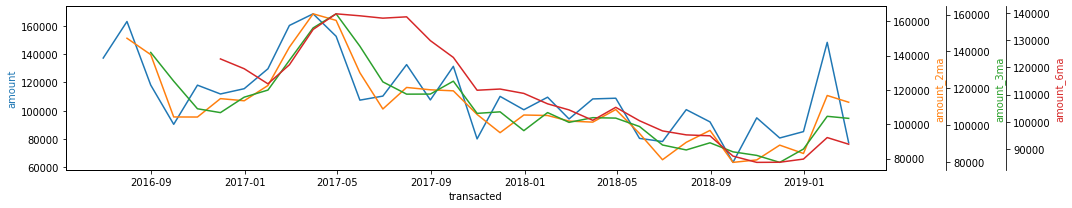

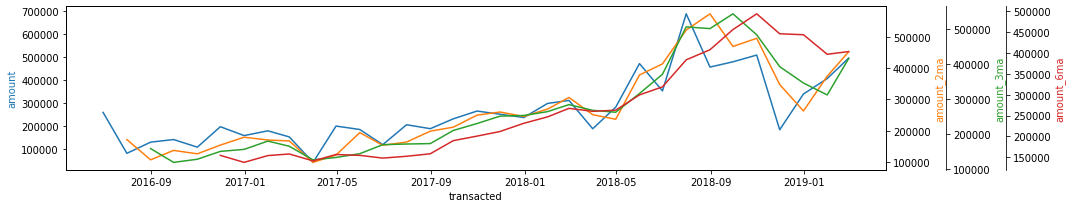

In [39]:
for i in sma_month['store_id'].unique()[:3]:
  plot_model_graph(sma_month, i, 'transacted', ['amount', 'amount_2ma', 'amount_3ma', 'amount_6ma'])

- 이동평균별 MAE 계산  

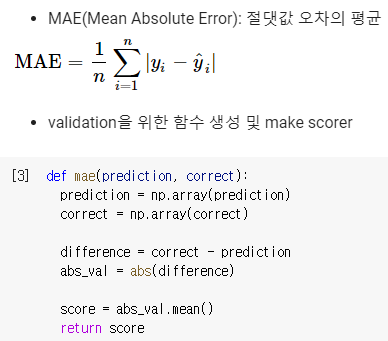

In [40]:
print('2 window SMA MAE Score:', mae(sma_month['amount_2ma'].fillna(0), sma_month['amount'].values))
print('3 window SMA MAE Score:', mae(sma_month['amount_3ma'].fillna(0), sma_month['amount'].values))
print('6 window SMA MAE Score:', mae(sma_month['amount_6ma'].fillna(0), sma_month['amount'].values))

2 window SMA MAE Score: 180687.25906004856
3 window SMA MAE Score: 251607.45528312284
6 window SMA MAE Score: 387465.0993765708


- window 3를 예시로 들면, t시점에 대한 값으로 t, t-1, t-2 시점의 평균을 사용한다.
- t시점을 위해 t-1, t-2, t-3의 평균을 구하는 것이므로 함수를 생성하여 진행

In [41]:
def make_minus_rolling(data_frame, rolling_num):
  def minus_shift_rolling(df_num, num):
    a = np.average(df_num.values[-num:])
    b = np.average(np.append(df_set.values[-(num-1):], a))
    if num > 2:
      c = np.average(np.append(np.append(df_set.values[-(num-2):], a), b))
    else:
      c = np.average((a, b))
    return np.sum((a, b, c))

  minus_rolling_arr = np.array([])
  for i in data_frame['store_id'].unique():
    df_set = pd.DataFrame(data_frame[data_frame['store_id']==i]['amount'])
    minus_rolling_arr = np.concatenate((minus_rolling_arr, np.array([minus_shift_rolling(df_set, rolling_num)])))

  df_rolling = pd.DataFrame({'store_id':df_sub['store_id'], 'amount':minus_rolling_arr})
    
  return df_rolling

In [42]:
for i in range(2, 5):
  df_rolling = make_minus_rolling(df_month, i)
  # df_rolling.to_csv('/content/drive/MyDrive/dacon/상점 신용카드 매출 예측/funda_{}_rolling_sub.csv'.format(i), index=False)

- SMA 2 rolling Score : 836184.506520
- SMA 3 rolling Score : 831158.397180
- SMA 4 rolling Score : 854300.339380

## __Exponential Moving Average__
- 지수이동평균은 가중이동평균 중 하나로, 단순이동평균보다 최근의 데이터에 높은 가중치를 부여하는 방법이다.  
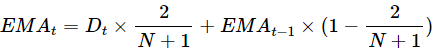

In [43]:
def make_ewm_arr(data_frame, span_num):
  arr_ewm = np.array([])
  for i in data_frame['store_id'].unique():
    df_set = data_frame[data_frame['store_id'] == i]
    # 여기에서 지정하는 span값은 위 수식의 N 값에 해당함
    arr_ewm = np.concatenate((arr_ewm, df_set['amount'].ewm(span = span_num).mean().values))
  
  return arr_ewm

In [44]:
ewm_month = df_month.copy()
ewm_month.insert(7, 'amount_3ewm', make_ewm_arr(ewm_month, 3))
ewm_month.insert(8, 'amount_6ewm', make_ewm_arr(ewm_month, 6))

In [45]:
ewm_month.head(3)

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount,amount_3ewm,amount_6ewm
transacted_date,,,,,,,,,
2016-06-30,0,25,17.0,145.0,77.0,13.0,7.470000e+05,747000.000000,747000.000000
2016-07-31,0,26,16.0,178.0,105.0,24.0,1.005000e+06,919000.000000,897500.000000
2016-08-31,0,24,16.0,171.0,97.0,69.0,8.715714e+05,891897.959184,885844.036697


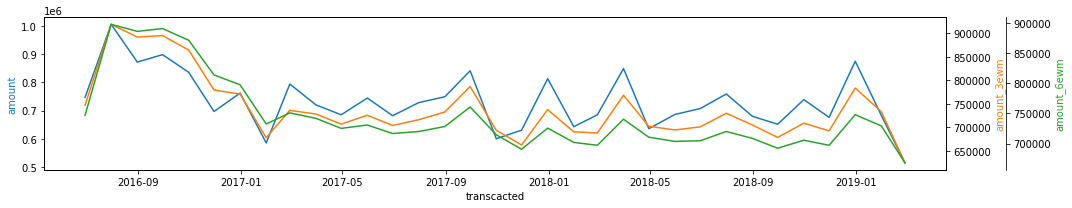

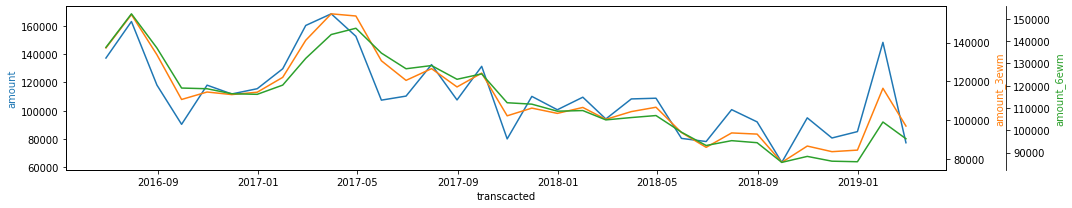

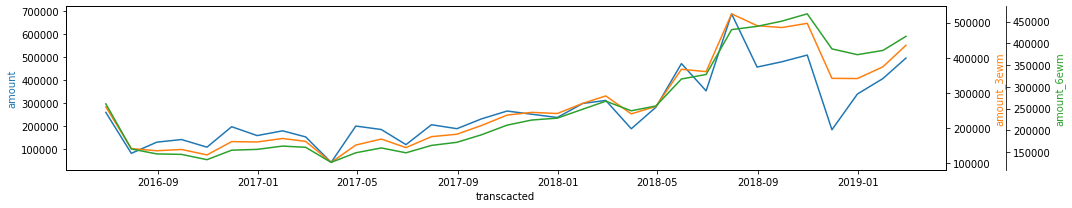

In [46]:
for i in ewm_month['store_id'].unique()[:3]:
  plot_model_graph(ewm_month, i, 'transcacted', ['amount', 'amount_3ewm', 'amount_6ewm'])

In [47]:
print('3 N EWM MAE Score: ', mae(ewm_month['amount_3ewm'], sma_month['amount'].values))
print('6 N EWM MAE Score: ', mae(ewm_month['amount_6ewm'], sma_month['amount'].values))

3 N EWM MAE Score:  134855.11946915495
6 N EWM MAE Score:  193447.63093078104


- 3~7 Exponentail Weighted Moving Score 확인

In [51]:
def make_wma_sub(data_frame, span_num):
  concat_3mon = pd.DataFrame(index=pd.to_datetime(['2019-03-31','2019-04-30','2019-05-31']))
  wma_sub = np.array([])
  for i in df_month['store_id'].unique():
    df_set = pd.DataFrame(data_frame[data_frame['store_id'] == i]['amount'])
    wma_train = pd.concat([df_set, concat_3mon], axis=0)
    num_sub = np.array([wma_train['amount'].ewm(span=span_num).mean()['2019-03':].sum()])
    wma_sub = np.concatenate((wma_sub, num_sub))
  df_wma_sub = pd.DataFrame({'store_id':df_sub['store_id'], 'amount':wma_sub})
  return df_wma_sub

In [52]:
for i in range(2,7):
  wma_sub = make_wma_sub(df_month, i)
  # wma_sub.to_csv('/content/drive/MyDrive/dacon/상점 신용카드 매출 예측/funda_{}_wma_sub.csv'.format(i), index=False)

- 2 span 제출 Score: 820102.106670
- 3 span 제출 Score: 785488.281930
- 4 span 제출 Score : 770667.895320
- 5 span 제출 Score : __767498.551420__
- 6 span 제출 Score : 770414.027040


## __Exponential Smoothing (지수평활법 - Simple, Holt's, Holt-Winter's)__

__1) Simple Exponential Smoothing__
- trend나 seasonality 반영 못함
- level 정도만 수평선으로 나옴  
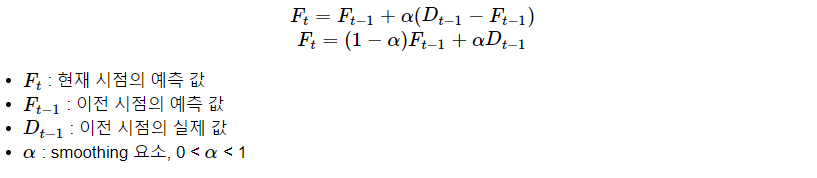


In [53]:
df_set = df_month[df_month['store_id'] == 0]
size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

ses_model = SimpleExpSmoothing(train['amount'])
ses_result = ses_model.fit()
ses_pred = ses_result.forecast(len(test))

In [54]:
print('store_id 0 mean value: ', df_set['amount'].mean())
print('MAE Score of test: ', mae(test['amount'], ses_pred))

store_id 0 mean value:  732559.7402597402
MAE Score of test:  78222.6492767349


In [55]:
def plot_train_test_pred_graph(trainset, testset, pred):
  plt.figure(figsize=(15,3))
  plt.plot(trainset['amount'], label='train')
  plt.plot(testset['amount'], label='test')
  plt.plot(testset.index, pred, label='prediction')
  plt.legend()
  plt.show()

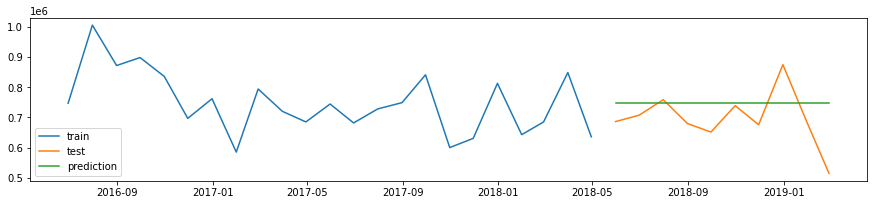

In [56]:
plot_train_test_pred_graph(train, test, ses_pred)

In [57]:
ses_pred_arr = np.array([])
for i in df_month['store_id'].unique():
  df_set = df_month[df_month['store_id'] == i]
  ses_model = SimpleExpSmoothing(df_set['amount'])
  ses_result = ses_model.fit()
  ses_pred = ses_result.forecast(3)

  ses_pred_arr = np.concatenate((ses_pred_arr, np.array([ses_pred.sum()])))

In [59]:
df_ses_sub = pd.DataFrame({'store_id': df_sub['store_id'], 'amount':ses_pred_arr})

- Simple Exponential Smoothing Score : 818205.82245